In [1]:
import os 
import os 
from torchcore.tools.get_statistics import get_dataset_category_statics
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

json_path = os.path.expanduser('~/data/datasets/Fashionpedia/annotations/instances_attributes_val2020.json')

fpGt=COCO(json_path)
names = [fpGt.cats[i]['name'] for i in range(len(fpGt.cats))]

path_train = os.path.expanduser('~/data/annotations/fashionpedia_instances_train.pkl')
path_val = os.path.expanduser('~/data/annotations/fashionpedia_instances_val.pkl')

result_train = get_dataset_category_statics(path_train, 'train', names)
result_val = get_dataset_category_statics(path_val, 'val', names)
#print(result)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def draw_hist(stat_dict, sorted=False, title=None):
    '''
    stat_dict: dict(category_name:item_number)
    sorted: do you what to sort the category distribution
    '''
    names=[]
    val = []
    for k,v in stat_dict.items():
        names.append(k)
        val.append(v)
    if sorted:
        val = np.array(val)
        order = np.argsort(val)
        names = np.array(names)
        names = names[order]
        val = val[order]

    x = np.arange(len(names))
    #plt.figure(figsize=(8,10))
    fig, ax = plt.subplots(figsize=(8,10))
    ax.barh(x, val,log=True, tick_label=names)
    ax.set_xlabel('Number')
    ax.set_ylabel('Category')
    ax.bar_label(ax.containers[0])
    if title is not None:
        ax.set_title(title)
    plt.show()
    

In [ ]:
draw_hist(result_train, sorted=True, title='Fashionpedia Train set distribution')

In [ ]:
draw_hist(result_val, sorted=True, title='Fashionpedia val set distribution')

In [ ]:
import os
from torchcore.data.datasets import FashionPediaDataset
anno_path_train = os.path.expanduser('~/data/annotations/fashionpedia_instances_train.pkl')
anno_path_val = os.path.expanduser('~/data/annotations/fashionpedia_instances_val.pkl')
root = os.path.expanduser('~/data/datasets/Fashionpedia')
dataset = FashionPediaDataset(anno=anno_path_train, part='train', root=root, transforms=None, add_mask=True) # the default transform in faster rcnn will be used
test_dataset = FashionPediaDataset(anno=anno_path_val, part='val', root=root, transforms=None, add_mask=True)

In [ ]:
dataset.set_category_subset([27])

In [ ]:
len(dataset)

In [ ]:
import matplotlib.pyplot as plt
from torchcore.tools.visulize_tools import draw_plain_boxes,draw_single_box
for i, (inputs, targets) in enumerate(dataset):
    if i<40:
        continue
    if i>50:
        break
    im = inputs['data']

    boxes = targets['boxes']
    draw_plain_boxes(im, boxes, color=(255,255,0))
    plt.figure()
    plt.imshow(im)
    

In [17]:
import os
import torch
from torchcore.data.transforms import RandomMirror, RandomAbsoluteScale, RandomCrop, Compose, AddSurrandingBox, AddPersonBox
from torchcore.data.datasets.fashion_pedia import FashionPediaDataset
from torchcore.data.collate import CollateFnRCNN, collate_fn_torchvision


t_mirrow = RandomMirror(probability=0)
#t_scale = RandomAbsoluteScale(cfg.max_size/2, cfg.max_size*2)
#t_crop = RandomCrop(cfg.max_size, box_inside=True)
transforms = Compose([t_mirrow])
transforms = None
min_size=1024
max_size=1024

anno_path_train = os.path.expanduser('~/data/annotations/fashionpedia_instances_train.pkl')
anno_path_val = os.path.expanduser('~/data/annotations/fashionpedia_instances_val.pkl')
root = os.path.expanduser('~/data/datasets/Fashionpedia')
t_person_box = AddPersonBox('fashionpedia_val_person.pkl', add_extra_dim=True, extend_to_target_boxes=True)
t_person_box_train = AddPersonBox('fashionpedia_train_person.pkl', add_extra_dim=True, extend_to_target_boxes=True)
#t_person_box = AddPersonBox('fashionpedia_val_person.pkl', add_extra_dim=True, extend_to_target_boxes=None, extend_ratio=1.1)
#t_person_box = AddPersonBox('fashionpedia_val_person.pkl', add_extra_dim=True )
t_scale = RandomAbsoluteScale(max_size, max_size, targets_box_keys=['boxes', 'input_box'], mask_key=None)
train_transforms = Compose([t_person_box_train, t_scale])
test_transforms = Compose([t_person_box, t_scale])
dataset = FashionPediaDataset(anno=anno_path_train, part='train', root=root, transforms=train_transforms) # the default transform in faster rcnn will be used
#test_dataset = FashionPediaDataset(anno=anno_path_train, part='train', root=root, transforms=test_transforms) # the default transform in faster rcnn will be used
test_dataset = FashionPediaDataset(anno=anno_path_val, part='val', root=root, transforms=test_transforms) # the default transform in faster rcnn will be used
test_dataset.set_category_subset(26, ignore_other_category=False)
dataset.set_category_subset(26, ignore_other_category=False)
#cfg.class_num = 46

collate_fn_rcnn_train = CollateFnRCNN(min_size=min_size, max_size=max_size, resized=False)
collate_fn_rcnn_test = CollateFnRCNN(min_size=min_size, max_size=max_size)

train_data_loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=1, 
        shuffle=False, 
        num_workers=0,
        #pin_memory=True,
        drop_last=True,
        collate_fn=collate_fn_rcnn_train)
data_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=1, 
        shuffle=False, 
        num_workers=0,
        #pin_memory=True,
        drop_last=True,
        collate_fn=collate_fn_rcnn_train)

In [3]:
import torch
from rcnn_config import config
from train_retinanet import get_model
from train_retinanet import load_checkpoint
cfg = config('retinanet_fashionpedia', os.path.expanduser('~/Vision/data'))
cfg.class_num = 46
device = torch.device( 'cpu' )
retinanet_model = get_model(cfg)
retinanet_model = retinanet_model.to(device)
path = '/home/dsv/qida0163/Vision/data/bbox/retinanet_fashionpedia/checkpoints/20210815_1024_fashionpedia_last.pth'
load_checkpoint(retinanet_model, path, device)


Chekpoint has been loaded from /home/dsv/qida0163/Vision/data/bbox/retinanet_fashionpedia/checkpoints/20210815_1024_fashionpedia_last.pth


In [4]:
from rcnn_config import config
from train_roi_frcnn import get_model
from train_roi_frcnn import load_checkpoint
cfg = config('frcnn_roi_fashionpedia', os.path.expanduser('~/Vision/data'))
cfg.class_num = 46
cfg.roi_head.class_num = 46
device = torch.device( 'cpu' )
frcnn_roi_model = get_model(cfg)
frcnn_roi_model = frcnn_roi_model.to(device)
path = '/home/dsv/qida0163/Vision/data/bbox/frcnn_roi_fashionpedia/checkpoints/20210605_128_0.8_1.3_last.pth'
load_checkpoint(frcnn_roi_model, path, device)

Chekpoint has been loaded from /home/dsv/qida0163/Vision/data/bbox/frcnn_roi_fashionpedia/checkpoints/20210605_128_0.8_1.3_last.pth


In [5]:
from rcnn_config import config
from train_retinanet_roi import get_model
from train_retinanet_roi import load_checkpoint
cfg = config('retinanet_roi_fashionpedia', os.path.expanduser('~/Vision/data'))
cfg.class_num = 46
device = torch.device( 'cpu' )
retinanet_roi_model = get_model(cfg)
retinanet_roi_model = retinanet_roi_model.to(device)
path = '/home/dsv/qida0163/Vision/data/bbox/retinanet_roi_fashionpedia/checkpoints/20210826_1024_fashionpedia_l1_128_double_lr_last.pth'
load_checkpoint(retinanet_roi_model, path, device)


Chekpoint has been loaded from /home/dsv/qida0163/Vision/data/bbox/retinanet_roi_fashionpedia/checkpoints/20210826_1024_fashionpedia_l1_128_double_lr_last.pth


In [6]:
import torch
from rcnn_config import config
from train_mask_rcnn import get_model
from train_mask_rcnn import load_checkpoint
cfg = config('mask_rcnn_fashionpedia', os.path.expanduser('~/Vision/data'))
cfg.class_num = 46
cfg.roi_head.class_num = 46
device = torch.device( 'cpu' )
frcnn_model = get_model(cfg)
frcnn_model = frcnn_model.to(device)
path = '/home/dsv/qida0163/Vision/data/bbox/mask_rcnn_fashionpedia/checkpoints/checkpoints_20210530_180000.pkl'
load_checkpoint(frcnn_model, path, device)

Chekpoint has been loaded from /home/dsv/qida0163/Vision/data/bbox/mask_rcnn_fashionpedia/checkpoints/checkpoints_20210530_180000.pkl


In [ ]:

from torchcore.tools.visulize_tools import draw_plain_boxes,draw_single_box,cv_put_text_with_box, cv_put_text, draw_single_image
from torchcore.tools.color_gen import random_colors
import matplotlib.pyplot as plt
from torchcore.data.util import set_device
import cv2
import numpy as np
model = frcnn_roi_model
model.eval()
colors = random_colors(46)
for i, (inputs,targets) in enumerate(data_loader):
    inputs = set_device(inputs, device)
    targets = set_device(targets, device)
    out = model(inputs,targets)
    input, target = test_dataset[i]
    im = input['data']
    #print(target['image_id'])
    #print(targets[0]['image_id'])
    
    boxes = out['boxes'][0].detach().cpu().numpy()
    keep = out['scores'][0].detach().cpu().numpy()>0.3
    boxes = boxes[keep]
    scores = out['scores'][0][keep]
    labels = out['labels'][0][keep]-1
    #print('boxes', boxes)
    #print('labels', labels)
    #print(target)
    
    draw_single_image(im,boxes,scores,labels,colors,names)

    #draw_plain_boxes(im, boxes, color=(255,255,0))
    #for box, label in zip(boxes, labels):
    #    box_cat = names[label-1]
    #    pos = tuple(box[:2].astype(int))
    #    im = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    #    cv_put_text_with_box(im, box_cat, pos,box_color=(255,255,255))
    #    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,12))
    #plt.imsave(fname, im)
    plt.imshow(im)
    if i>=10:
        break

In [7]:
import os
from torchcore.tools.visulize_tools import draw_plain_boxes,draw_single_box,cv_put_text_with_box, cv_put_text, draw_single_image
from torchcore.tools.color_gen import random_colors
import matplotlib.pyplot as plt
from PIL import Image
from torchcore.data.util import set_device
import cv2
import numpy as np
def save_results(data_loader, dataset, model, save_folder, color_num, device, prefix=''):
    model.eval()
    colors = random_colors(color_num)
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    for i, (inputs,targets) in enumerate(data_loader):
        inputs = set_device(inputs, device)
        targets = set_device(targets, device)
        out = model(inputs,targets)
        input, target = dataset[i]
        im = input['data']
        #print(target['image_id'])
        #print(targets[0]['image_id'])
        
        boxes = out['boxes'][0].detach().cpu().numpy()
        keep = out['scores'][0].detach().cpu().numpy()>0.3
        boxes = boxes[keep]
        scores = out['scores'][0][keep]
        labels = out['labels'][0][keep]-1
        
        draw_single_image(im,boxes,scores,labels,colors,names)

        fname = os.path.join(save_folder, '{}{:04d}.jpg'.format(prefix,i+1))
        im.save(fname)
        

In [19]:
def save_gt(dataset, save_folder, color_num, prefix=''):
    colors = random_colors(color_num)
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    for i in range(len(dataset)):
        input, target = dataset[i]
        im = input['data']
        boxes =target['boxes']
        labels = target['labels']-1
        
        draw_single_image(im,boxes,None,labels,colors,names)

        fname = os.path.join(save_folder, '{}{:04d}.jpg'.format(prefix,i+1))
        im.save(fname)


In [20]:
save_gt(test_dataset, 'results/gt_scarf', 46, prefix='val')

In [10]:

save_results(data_loader, test_dataset, retinanet_model, 'results/retinanet_scarf', 46, device, prefix='val')
save_results(data_loader, test_dataset, retinanet_roi_model, 'results/retinanet_roi_scarf', 46, device, prefix='val')
save_results(data_loader, test_dataset, frcnn_roi_model, 'results/frcnn_roi_scarf', 46, device, prefix='val')
save_results(data_loader, test_dataset, frcnn_model, 'results/frcnn_scarf', 46, device, prefix='val')

In [72]:
save_results(data_loader, test_dataset, retinanet_model, 'results/retinanet', 46, device, prefix='val')
save_results(train_data_loader, dataset, retinanet_model, 'results/retinanet', 46, device, prefix='train')

In [73]:
save_results(data_loader, test_dataset, retinanet_roi_model, 'results/retinanet_roi', 46, device, prefix='val')
save_results(train_data_loader, dataset, retinanet_roi_model, 'results/retinanet_roi', 46, device, prefix='train')

In [74]:
save_results(data_loader, test_dataset, frcnn_roi_model, 'results/frcnn_roi', 46, device, prefix='val')
save_results(train_data_loader, dataset, frcnn_roi_model, 'results/frcnn_roi', 46, device, prefix='train')

In [75]:
save_results(data_loader, test_dataset, frcnn_model, 'results/frcnn', 46, device, prefix='val')
save_results(train_data_loader, dataset, frcnn_model, 'results/frcnn', 46, device, prefix='train')

In [12]:
import os
from PIL import Image
from PIL.ImageDraw import Draw
from torchcore.tools.visulize_tools import get_font
def combine_images(file_name, out_folder, in_folder_path, model_names):
    if not os.path.isdir(out_folder):
        os.makedirs(out_folder)
    ims = []
    font = get_font(36)
    for name,fpath in zip(model_names, in_folder_path):
        path = os.path.join(fpath, file_name)
        im = Image.open(path)
        im_draw=Draw(im)
        im_draw.text((0,0), name, font=font)
        ims.append(im)
    width, height = ims[0].size
    new_im = Image.new('RGB', (width*2, height*2))

    for i,im in enumerate(ims):
        x_off = i%2
        y_off = i//2
        new_im.paste(im, (width*x_off,height*y_off))
    out_path = os.path.join(out_folder, file_name)
    new_im.save(out_path)

In [13]:
file_names = os.listdir('results/retinanet_scarf')
out_folder = 'results/combine_scarf'
model_names = ['retinanet', 'retinanet_roi', 'frcnn', 'frcnn_roi']
in_folder_path = ['results/retinanet_scarf', 'results/retinanet_roi_scarf', 'results/frcnn_scarf', 'results/frcnn_roi_scarf']
for file_name in file_names:
    combine_images(file_name, out_folder, in_folder_path, model_names)

In [21]:
import os
from PIL import Image
from PIL.ImageDraw import Draw
from torchcore.tools.visulize_tools import get_font
def combine_images_with_gt(file_name, out_folder, in_folder_path, gt_folder, model_names):
    if not os.path.isdir(out_folder):
        os.makedirs(out_folder)
    ims = []
    font = get_font(36)
    for name,fpath in zip(model_names, in_folder_path):
        path = os.path.join(fpath, file_name)
        im = Image.open(path)
        im_draw=Draw(im)
        im_draw.text((0,0), name, font=font)
        ims.append(im)

    gt_path = os.path.join(gt_folder,file_name)
    gt_im = Image.open(gt_path)
    im_draw=Draw(gt_im)
    im_draw.text((0,0), 'groundtruth', font=font)

    width, height = ims[0].size
    new_im = Image.new('RGB', (width*4, height*2))

    for i,im in enumerate(ims):
        x_off = i%2
        y_off = i//2
        new_im.paste(im, (width*x_off,height*y_off))
    gt_im = gt_im.resize((width*2, height*2))
    new_im.paste(gt_im, (width*2, 0))
    out_path = os.path.join(out_folder, file_name)
    new_im.save(out_path)

In [22]:

file_names = os.listdir('results/retinanet_scarf')
out_folder = 'results/combine_scarf'
model_names = ['retinanet', 'retinanet_roi', 'frcnn', 'frcnn_roi']
in_folder_path = ['results/retinanet_scarf', 'results/retinanet_roi_scarf', 'results/frcnn_scarf', 'results/frcnn_roi_scarf']
gt_folder = 'results/gt_scarf'
for file_name in file_names:
    combine_images_with_gt(file_name, out_folder, in_folder_path,gt_folder, model_names)

In [35]:
from PIL import Image
from PIL.ImageDraw import Draw
from torchcore.tools.visulize_tools import get_font
def gen_color_table(color_num, names, bin_width=50, bin_height=20):
    font = get_font(20)
    colors = random_colors(color_num)
    im = Image.new('RGB', (bin_width, bin_height*color_num))
    im_draw = Draw(im)
    for i, (color, name) in enumerate(zip(colors, names)):
        im_draw.rectangle([0, i*bin_height, bin_width, (i+1)*bin_height],outline=color, fill=color)
        im_draw.text((0,i*bin_height), name, font=font, fill=(0,0,0))
    return im

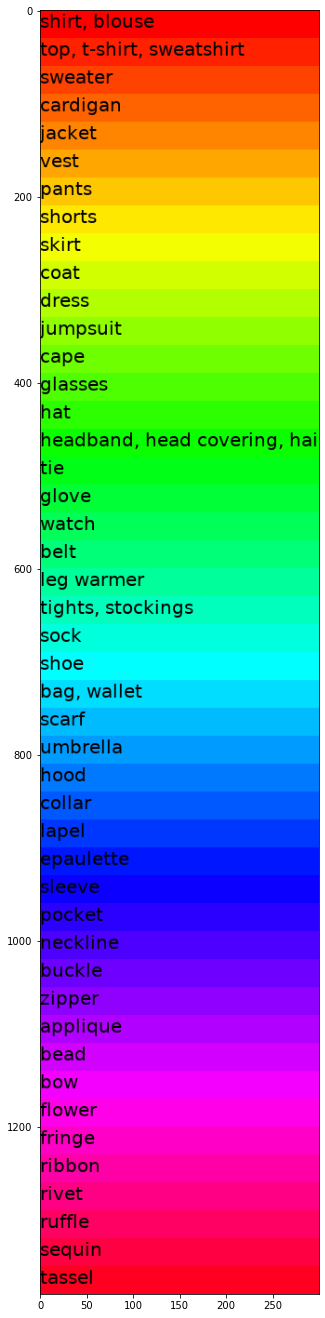

In [36]:
import matplotlib.pyplot as plt
color_table = gen_color_table(46, names,bin_width=300, bin_height=30)
plt.figure(figsize=(5,30))
plt.imshow(color_table)


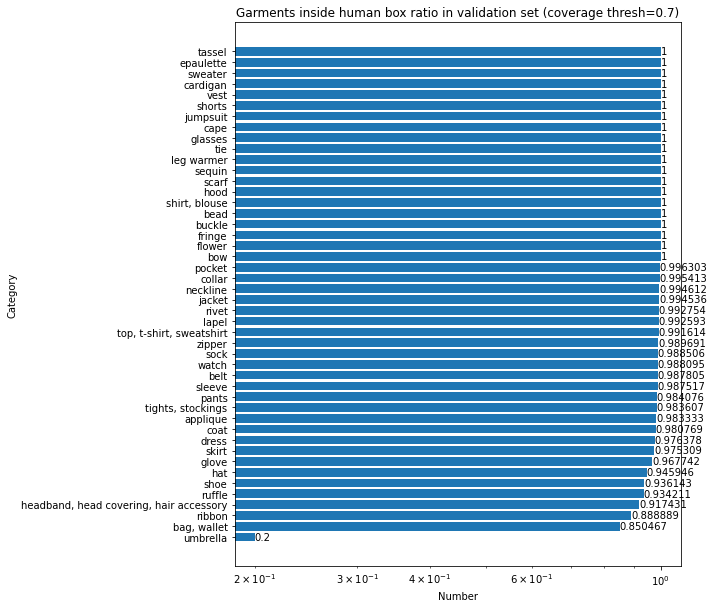

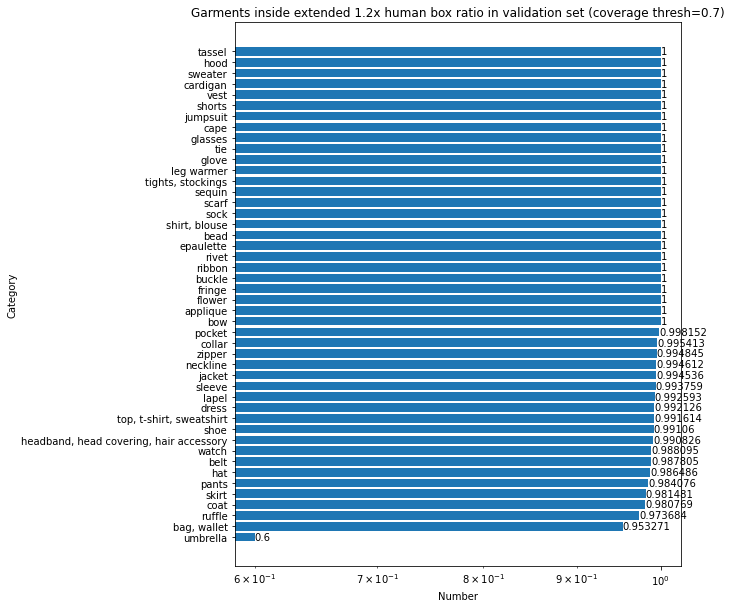

In [57]:
from torchcore.tools.get_statistics import get_garments_in_human_statistics
import pickle

part = 'val'
human_det_path = 'fashionpedia_val_person_origin.pkl'

with open(anno_path_val, 'rb') as f:
    imageset = pickle.load(f)[part]
with open(human_det_path, 'rb') as f:
    human_detections = pickle.load(f)
#image_test(human_detections, imageset, root)
g_in, g_in_ext, garments_num = get_garments_in_human_statistics(human_detections, imageset, category_num=46, expand_rate=0.2, gen_id_map=False, print_result=False)

g_in_ratio = g_in / garments_num
g_in_ext_ratio = g_in_ext / garments_num

g_in_dict = {k:v for k,v in zip(names,g_in_ratio)}
g_in_ext_dict = {k:v for k,v in zip(names,g_in_ext_ratio)}

draw_hist(g_in_dict, sorted=True, title='Garments inside human box ratio in validation set (coverage thresh=0.7)')
draw_hist(g_in_ext_dict, sorted=True, title='Garments inside extended 1.2x human box ratio in validation set (coverage thresh=0.7)')


image 45829 has no human detection
image 49647 has no human detection
image 49200 has no human detection
image 36402 has no human detection
image 34494 has no human detection


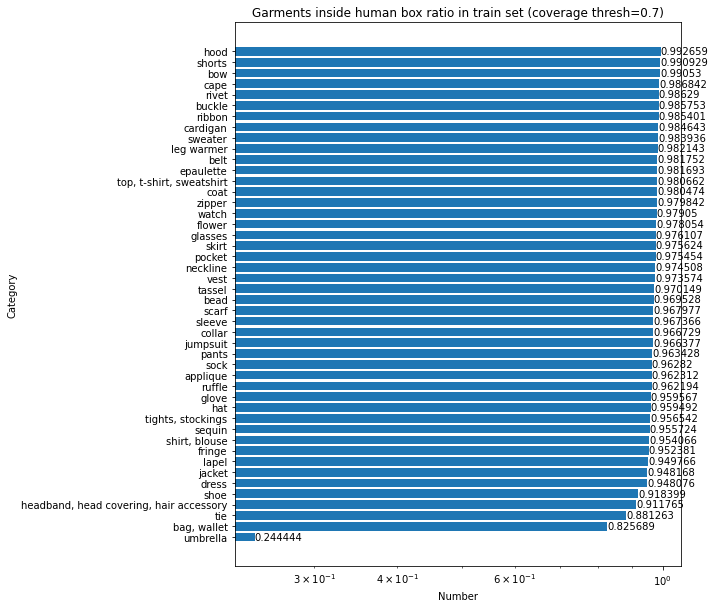

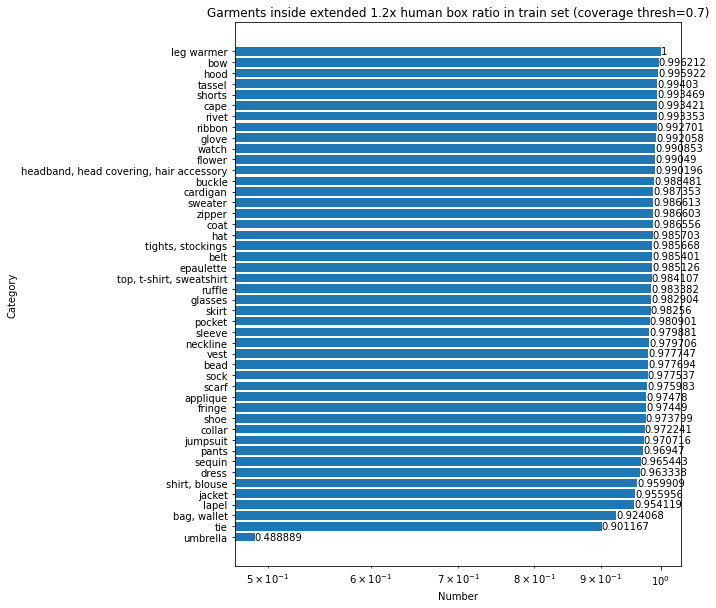

In [60]:
from torchcore.tools.get_statistics import get_garments_in_human_statistics
import pickle

part = 'train'
human_det_path = 'fashionpedia_train_person_origin.pkl'

with open(anno_path_train, 'rb') as f:
    imageset = pickle.load(f)[part]
with open(human_det_path, 'rb') as f:
    human_detections = pickle.load(f)
#image_test(human_detections, imageset, root)
g_in, g_in_ext, garments_num = get_garments_in_human_statistics(human_detections, imageset, category_num=46, expand_rate=0.2, gen_id_map=False, print_result=False)

g_in_ratio = g_in / garments_num
g_in_ext_ratio = g_in_ext / garments_num

g_in_dict = {k:v for k,v in zip(names,g_in_ratio)}
g_in_ext_dict = {k:v for k,v in zip(names,g_in_ext_ratio)}

draw_hist(g_in_dict, sorted=True, title='Garments inside human box ratio in train set (coverage thresh=0.7)')
draw_hist(g_in_ext_dict, sorted=True, title='Garments inside extended 1.2x human box ratio in train set (coverage thresh=0.7)')